In [ ]:
from pyimagesearch import config
from imutils import paths
import random
import shutil
import os

# grab the paths to all input images in the original input directory
# and shuffle them
imagePaths = list(paths.list_images(config.ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

# compute the training and testing split
i = int(len(imagePaths) * config.TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

# we'll be using part of the training data for validation
i = int(len(trainPaths) * config.VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

# define the datasets that we'll be building
datasets = [
	("training", trainPaths, config.TRAIN_PATH),
	("validation", valPaths, config.VAL_PATH),
	("testing", testPaths, config.TEST_PATH)
]

# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))

	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)

	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image along with its
		# corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]

		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])

		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)

		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

In [10]:
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from pyimagesearch.resnet import ResNet
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# initialize the number of training epochs and batch size
DATASET = 'streetart'
NUM_EPOCHS = 30
BS = 32
IMAGE_NAME = 'plot.png'
MODEL_NAME = 'save_model.model'

# derive the path to the directories containing the training,
# validation, and testing splits, respectively
TRAIN_PATH = os.path.sep.join([DATASET, "training"])
VAL_PATH = os.path.sep.join([DATASET, "validation"])
TEST_PATH = os.path.sep.join([DATASET, "testing"])

# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.05,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

# initialize the training generator
trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=True,
	batch_size=32)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

# initialize our Keras implementation of ResNet model and compile it
model = ResNet.build(64, 64, 3, 2, (2, 2, 3),
	(32, 64, 128, 256), reg=0.0005)
opt = SGD(lr=1e-1, momentum=0.9, decay=1e-1 / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train our Keras model
H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	epochs=NUM_EPOCHS)

# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
	steps=(totalTest // BS) + 1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))

# save the network to disk
print("[INFO] serializing network to '{}'...".format(MODEL_NAME))
model.save(save_model.model)

# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(IMAGE_NAM)

Found 4511 images belonging to 2 classes.
Found 501 images belonging to 2 classes.
Found 1254 images belonging to 2 classes.
Epoch 1/30
 64/140 [============>.................] - ETA: 1:13 - loss: 0.9028 - acc: 0.6406

KeyboardInterrupt: 

[INFO] loading pre-trained network...
[INFO] evaluating model against test set...
[INFO] building image montage of results...


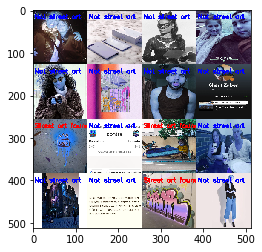

In [9]:
# USAGE
# python load_model.py --images malaria/testing --model saved_model.model

# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from imutils import build_montages
from imutils import paths
from matplotlib import pyplot as plt
import numpy as np
import argparse
import random
import cv2

MODEL_NAME = 'old_saved_model.model'
SAVED_MONTAGE_PATH = 'montage.png'
IMAGES_PATH = 'streetart/testing'

# load the pre-trained network
print("[INFO] loading pre-trained network...")
model = load_model(MODEL_NAME)

# grab all image paths in the input directory and randomly sample them
imagePaths = list(paths.list_images(IMAGES_PATH))
random.shuffle(imagePaths)
imagePaths = imagePaths[:16]

# initialize our list of results
results = []

# loop over our sampled image paths
print("[INFO] evaluating model against test set...")
for p in imagePaths:
	# load our original input image
	orig = cv2.imread(p)

	# pre-process our image by converting it from BGR to RGB channel
	# ordering (since our Keras mdoel was trained on RGB ordering),
	# resize it to 64x64 pixels, and then scale the pixel intensities
	# to the range [0, 1]
	image = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (64, 64))
	image = image.astype("float") / 255.0

	# order channel dimensions (channels-first or channels-last)
	# depending on our Keras backend, then add a batch dimension to
	# the image
	image = img_to_array(image)
	image = np.expand_dims(image, axis=0)

	# make predictions on the input image
	pred = model.predict(image)
	pred = pred.argmax(axis=1)[0]

	# an index of zero is the 'parasitized' label while an index of
	# one is the 'uninfected' label
	label = "Not street art" if pred == 0 else "Street art found"
	color = (0, 0, 255) if pred == 0 else (255, 0, 0)

	# resize our original input (so we can better visualize it) and
	# then draw the label on the image
	orig = cv2.resize(orig, (128, 128))
	cv2.putText(orig, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
		color, 2)

	# add the output image to our list of results
	results.append(orig)

print("[INFO] building image montage of results...")
# create a montage using 128x128 "tiles" with 4 rows and 4 columns
montage = build_montages(results, (128, 128), (4, 4))[0]
cv2.imwrite(SAVED_MONTAGE_PATH, montage)

img = cv2.imread('montage.png')
img2 = img[:,:,::-1]
plt.imshow(img)

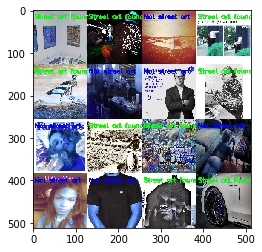

In [5]:
img = cv2.imread('montage.png')
img2 = img[:,:,::-1]
plt.imshow(img)